# Problem 3

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 128
(full_dim, mid_dim, hidden) = (1 * 28 * 28, 1000, 5)
lr = 1e-3
epochs = 100
device = torch.device("cpu")

In [3]:
############################################
# STEP 1: Define dataset and preprocessing #
############################################

#####################################
# STEP 2: Define prior distribution #
#####################################

class Logistic(torch.distributions.Distribution):
    def __init__(self):
        super(Logistic, self).__init__()

    def log_prob(self, x):
        return -(F.softplus(x) + F.softplus(-x))

    def sample(self, size):
        z = torch.distributions.Uniform(0., 1.).sample(size).to(device)
        return torch.log(z) - torch.log(1. - z)

In [4]:
####################################
# STEP 3: Implement Coupling Layer #
####################################

class Coupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, hidden, mask_config):
        super(Coupling, self).__init__()
        self.mask_config = mask_config
        
        self.in_block = nn.Sequential(nn.Linear(in_out_dim//2, mid_dim), nn.ReLU())
        self.mid_block = nn.ModuleList([nn.Sequential(nn.Linear(mid_dim, mid_dim), nn.ReLU())
                                                                 for _ in range(hidden - 1)])
        self.out_block = nn.Linear(mid_dim, in_out_dim//2)

    def forward(self, x, reverse=False):
        [B, W] = list(x.size())
        x = x.reshape((B, W//2, 2))
        if self.mask_config:
            on, off = x[:, :, 0], x[:, :, 1]
        else:
            off, on = x[:, :, 0], x[:, :, 1]

        off_ = self.in_block(off)
        for i in range(len(self.mid_block)):
            off_ = self.mid_block[i](off_)
        shift = self.out_block(off_)
        
        if reverse:
            on = on - shift
        else:
            on = on + shift

        if self.mask_config:
            x = torch.stack((on, off), dim=2)
        else:
            x = torch.stack((off, on), dim=2)
        return x.reshape((B, W))

class Scaling(nn.Module):
    def __init__(self, dim):
        super(Scaling, self).__init__()
        self.scale = nn.Parameter(torch.zeros((1, dim)), requires_grad=True)

    def forward(self, x, reverse=False):
        log_det_J = torch.sum(self.scale)
        if reverse:
            x = x * torch.exp(-self.scale)
        else:
            x = x * torch.exp(self.scale)
        return x, log_det_J

In [5]:
##########################
# STEP 4: Implement NICE #
##########################

class NICE(nn.Module):
    def __init__(self,in_out_dim, mid_dim, hidden, mask_config=1.0, coupling=4):
        super(NICE, self).__init__()
        self.prior = Logistic()
        self.in_out_dim = in_out_dim

        self.coupling = nn.ModuleList([
            Coupling(in_out_dim=in_out_dim, 
                     mid_dim=mid_dim, 
                     hidden=hidden, 
                     mask_config=(mask_config+i)%2) \
            for i in range(coupling)])
        
        self.scaling = Scaling(in_out_dim)

    def g(self, z):
        x, _ = self.scaling(z, reverse=True)
        for i in reversed(range(len(self.coupling))):
            x = self.coupling[i](x, reverse=True)
        return x

    def f(self, x):
        for i in range(len(self.coupling)):
            x = self.coupling[i](x)
        z, log_det_J = self.scaling(x)
        return z, log_det_J

    def log_prob(self, x):
        z, log_det_J = self.f(x)
        log_ll = torch.sum(self.prior.log_prob(z), dim=1)
        return log_ll + log_det_J

    def sample(self, size):
        z = self.prior.sample((size, self.in_out_dim)).to(device)
        return self.g(z)

    def forward(self, x):
        return self.log_prob(x)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class '__main__.Logistic'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


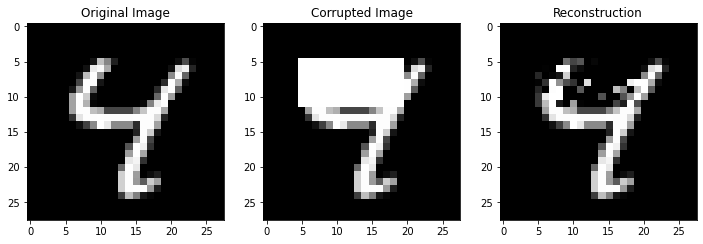

In [6]:
# Load pre-trained NICE model onto CPU
model = NICE(in_out_dim=784, mid_dim=1000, hidden=5).to(device)
model.load_state_dict(torch.load('nice.pt',map_location=torch.device('cpu')))

# Since we do not update model, set requires_grad = False
model.requires_grad_(False)

# Get an MNIST image
testset = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
pass_count = 6
itr = iter(test_loader)
for _ in range(pass_count+1):
    image,_ = itr.next()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.set_title('Original Image')
ax1.imshow(make_grid(image.squeeze().detach()).permute(1,2,0))
# ax1.savefig('plt1.png')

# Create mask 
mask = torch.ones_like(image,dtype=torch.bool)
mask[:,:,5:12,5:20] = 0

# Partially corrupt the image
image[mask.logical_not()] = torch.ones_like(image[mask.logical_not()])
ax2.set_title('Corrupted Image')
ax2.imshow(make_grid(image.squeeze()).permute(1,2,0))
# ax2.savefig('plt2.png')

# Plot reconstruction
X = image.clone().requires_grad_(True)
for i in range(300):
    X.data = X.data.view(-1, 28*28)
    loss = -model(X)
    loss.backward()
    X.data = torch.clamp(X.data - lr * X.grad, min=0, max=1)
    X.data[mask.view(-1, 28*28).logical_not().logical_not()] = image.view(-1, 28*28)[mask.view(-1, 28*28).logical_not().logical_not()]
X.data = X.data.view(image.size())

ax3.set_title('Reconstruction')
ax3.imshow(make_grid(X.squeeze().detach()).permute(1,2,0))
# ax3.savefig('plt3.png')

plt.show()

# Problem 5

In [7]:
import torch
import math

N = 3000
p = 18. / 37.
q = 0.55
max_play = 600

def f(X_i):
    return p**X_i * (1-p)**(1-X_i)

def g(Y_i):
    return q**Y_i * (1-q)**(1-Y_i)

samp = []
for _ in range(N):
    Y = torch.bernoulli(q * torch.ones(max_play))
    balance = 100
    s = 1
    for i in range(max_play):
        balance += 2*Y[i]-1
        s *= f(Y[i]) / g(Y[i])
        if balance == 0 or balance == 200:
            break
    s *= (balance == 200).float()
    samp.append(s)

samp = torch.Tensor(samp)
Ihat,s = samp.mean(), samp.var()
print(f"Estimate: {Ihat:.6f} ± {math.sqrt(s/N):.6f}")

Estimate: 0.000002 ± 0.000000


# Problem 6

## (a)

In [16]:
import torch
import math

lr = 1e-3
B = 16
iterations = 500
mu = torch.tensor([0.])
tau = torch.tensor([0.])

for itr in range(iterations):
    X = torch.normal(0, 1, size=(B,)) * tau.exp() + mu
    mu -= lr * (torch.sum(X * X.sin() * (X - mu) / tau.exp()**2) / B + mu - 1)
    tau -= lr * (torch.sum(X * X.sin() * ((X - mu)**2 / tau.exp() - 1)) / B + tau.exp() - 1)

print(f"mu = {mu[0]}")
print(f"sigma = {tau.exp()[0]}")

mu = 0.3323487937450409
sigma = 0.8285127878189087
tensor([7.1168])


## (b)

In [9]:
import torch
import math

lr = 1e-3
B = 16
iterations = 500
mu = torch.tensor([0.])
tau = torch.tensor([0.])

for itr in range(iterations):
    Y = torch.normal(0, 1, size=(B,))
    X = mu + tau.exp() * Y
    mu -= lr * (torch.sum(X.sin() + X * X.cos()) / B + mu - 1)
    tau -= lr * (torch.sum((X.sin() + X * X.cos()) * Y) / B + tau.exp() - 1)
    
print(f"mu = {mu[0]}")
print(f"sigma = {tau.exp()[0]}")

mu = 0.3241511881351471
sigma = 0.7526840567588806
